In [ ]:
# @title Importamos librerias

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import sklearn.linear_model as lm
import sklearn as sk
from sklearn import linear_model

# import seaborn as sns
# import random

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Import Data

In [ ]:
# @title Recuperamos los datos
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Cargamos los datos
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(list(dat.keys()))

['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz']


# Decodificando comportamiento de la actividad neuronal

## El dataset

El dataset que vamos a usar fue tomado de *Stringer et al., figshare
(2018)*; *Steinmetz et al., figshare (2019)*. Los datos incluyen imagenes de calcio multi-plano de dos fotones de ∼10,000 neuronas en la corteza visual primaria (V1) de ratones despiertos con la cabeza fija. Ademas, los datos contienen las coordenadas cartesianas en 3D cada neurona, que estan ubicadas sobre distintos planos a distintas profundidades. Los registros corresponden a ratones realizando actividad espontanea en ausencia de estimulos.

La corteza visual esta compuesta por 6 capas corticales, cada una de las cuales tiene inputs y outputs especificos dentro del circuito visual. Ademas, capas especificas de V1 tienen correlaciones al comportamiento (como velocidad, area de pupila y $whisking$).

La idea es ver que podemos decodificar (¡predecir!) algunas de estas variables comportamentales proponiendo un modelo lineal que tome como inputs las tasas de disparo de las neuronas a tiempo $t$ y nos de como output nuestra variable a predecir.



## Visualicemos un poco los datos

Text(0, 0.5, 'Tasas de disparo (offset corrido por neurona)')

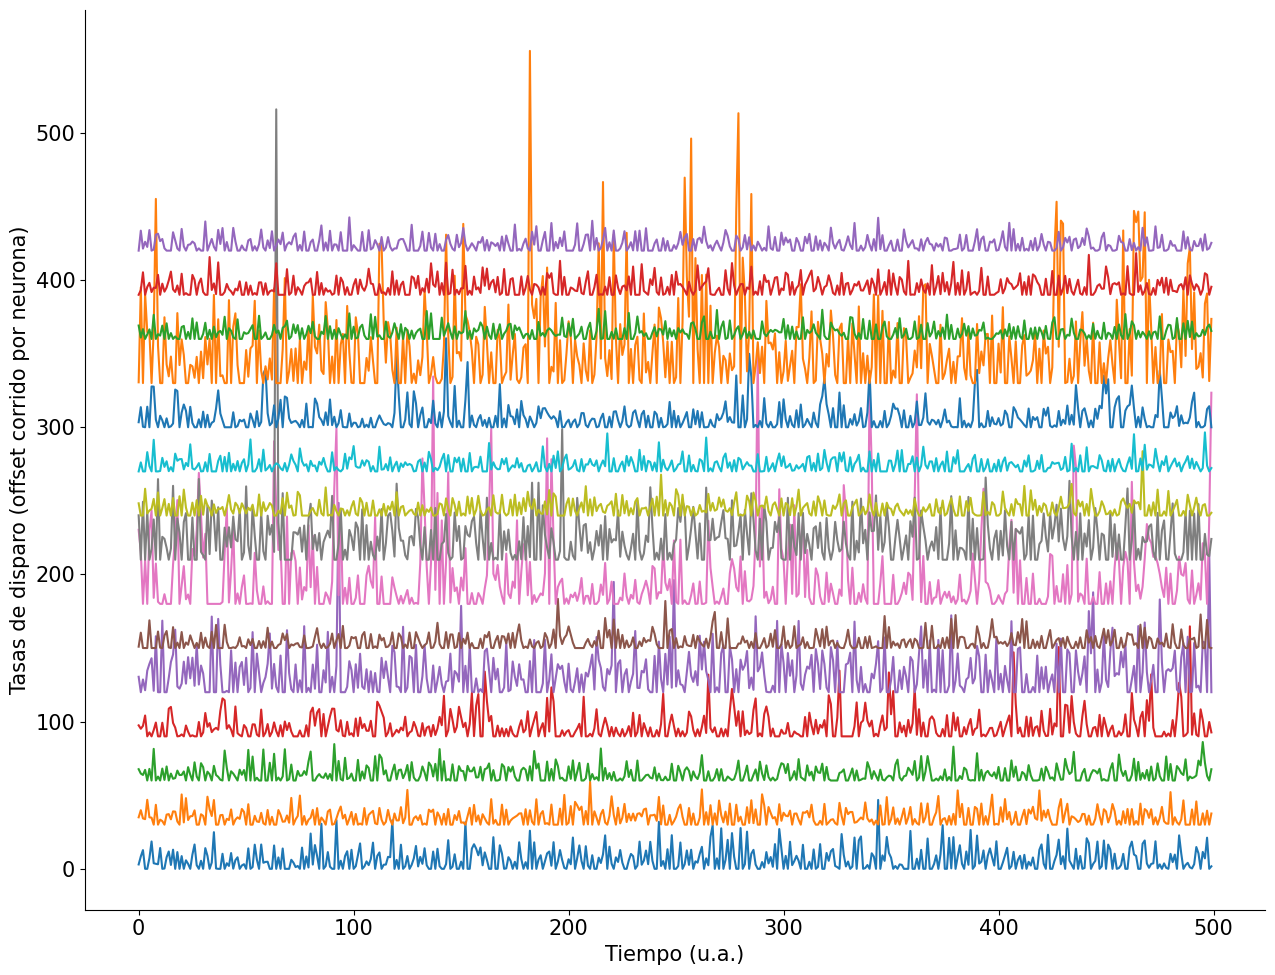

In [ ]:
#@title Tasas de disparo
plt.figure(figsize=(13,10))
for i in range(15):
  plt.plot(dat['sresp'][i,:500]+i*30)
plt.xlabel('Tiempo (u.a.)')
plt.ylabel('Tasas de disparo (offset corrido por neurona)')

Text(0.5, 0, 'Tiempo (u.a.)')

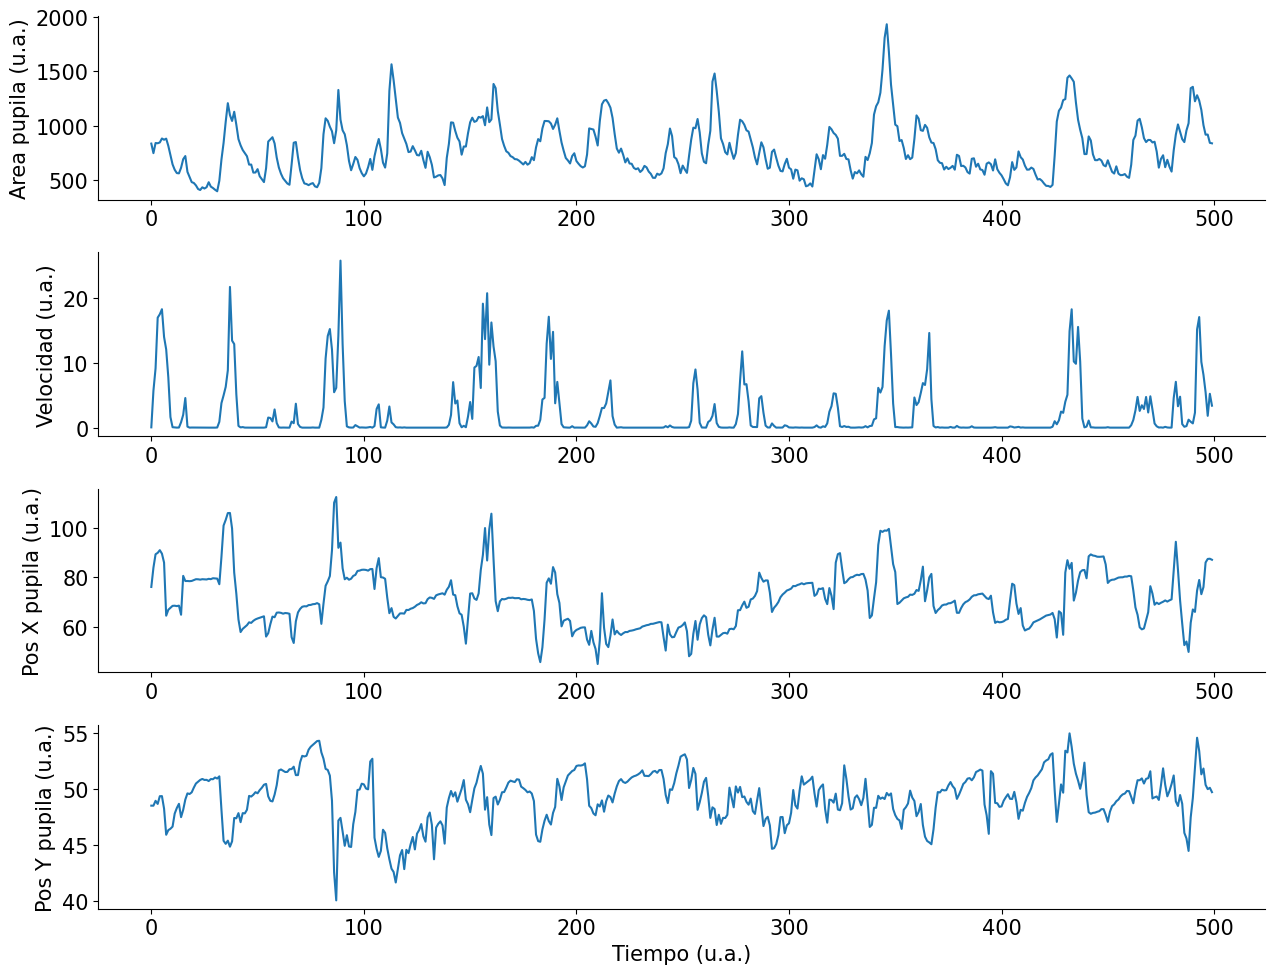

In [ ]:
#@title Variables comportamentales
plt.figure(figsize=(13,10))
plt.subplot(4,1,1)
plt.plot(dat['pupilArea'][:500])
plt.ylabel('Area pupila (u.a.)')
plt.subplot(4,1,2)
plt.plot(dat['run'][:500])
plt.ylabel('Velocidad (u.a.)')
plt.subplot(4,1,3)
plt.plot(dat['pupilCOM'][:500,0])
plt.ylabel('Pos X pupila (u.a.)')
plt.subplot(4,1,4)
plt.plot(dat['pupilCOM'][:500,1])
plt.ylabel('Pos Y pupila (u.a.)')
plt.xlabel('Tiempo (u.a.)')

## Preparamos y normalizamos los datos

Cuando tenemos datos muy heterogeneos (como pueden ser las tasas de disparo de neuronas), una practica comun es normalizaros. El tipo de normalizacion va a depender de la naturaleza misma de los datos y de que estemos buscando de ellos (no hay una unica receta, y no todas las normalizaciones son validas para todos los datos, asi que hay que tener criterio). En nuestro caso, por lo general podemos inferir el contenido de informacion en la tasa de disparo se una neurona segun cuanto se desvie de su media de disparo. Por esta razon, es razonable normalizar el dataset usando el *z-score*

$$z_i = \frac{x_i-\mu}{\sigma} $$

Basicamente estamos centrando las variables a la media del dataset y normalizandolo por su desviacion estandar (en general lo mas correcto es tomar la media y desviacion estandar del dataset para no afectar las correlaciones, pero pueden haber excepciones).

In [ ]:
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

Una vez normalizados, podemos analizar cualitativamente nuestra data (que es multidimensional y bastante compleja), calculando las primeras componentes principales del *z-score* calculado y viendo su relacion con las variables comportamentales medidas.

In [ ]:
pca_model = PCA(n_components=100)
pca_zscore = pca_model.fit_transform(Z.T)

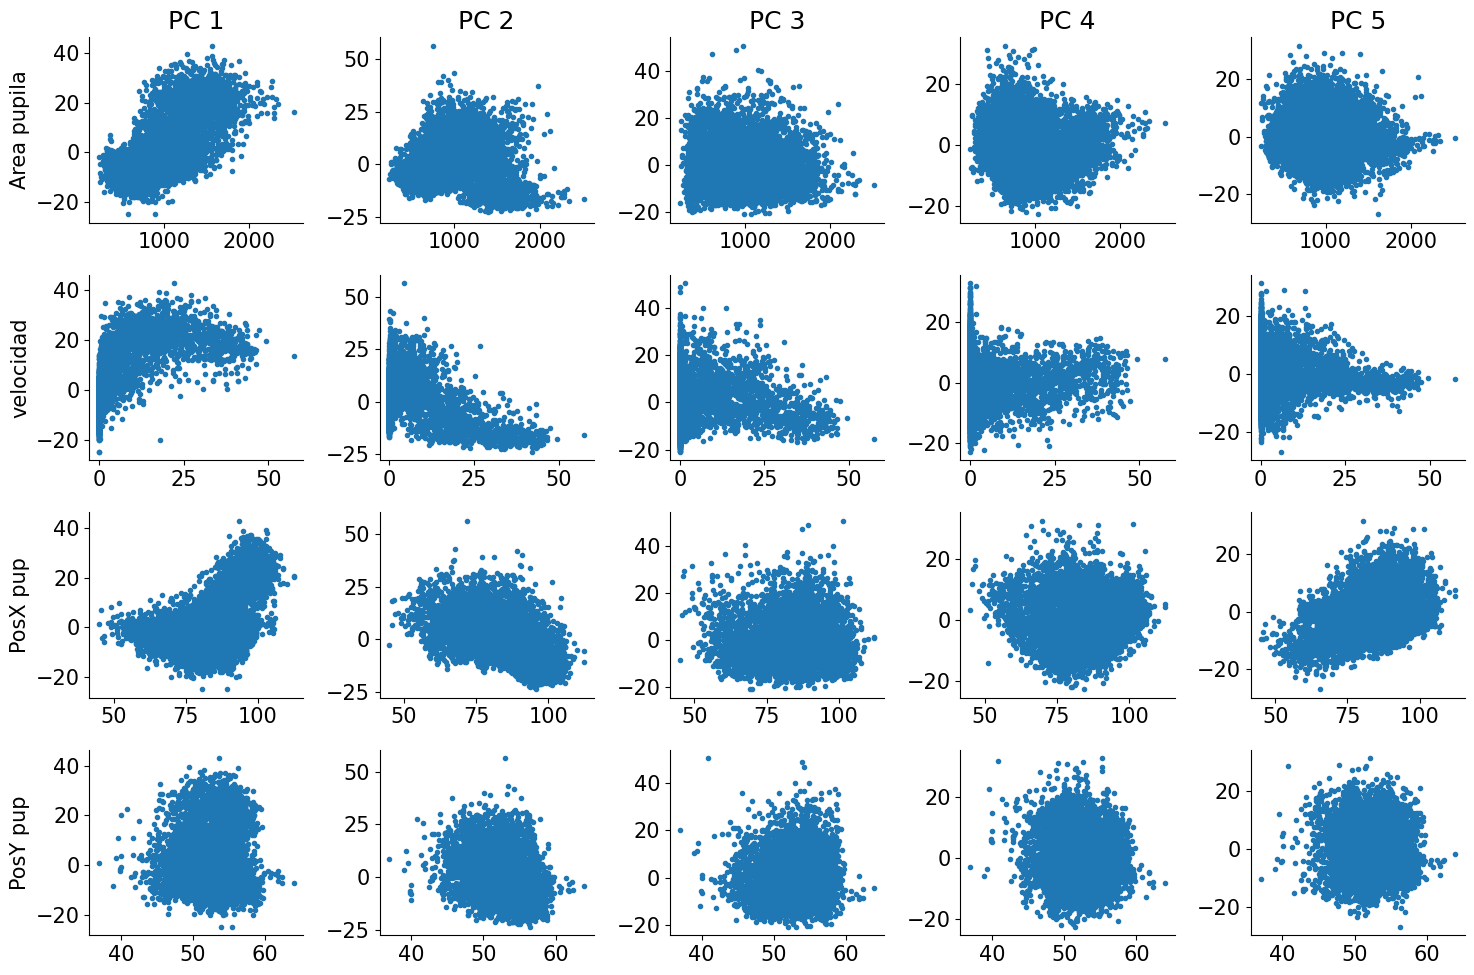

In [ ]:
NUMPCA = 5
NUMVARS = 4

plt.figure(figsize=(15,10))
for i in range(NUMPCA):

  plt.subplot(NUMVARS,NUMPCA,i+1)
  plt.title('PC '+str(i+1))
  plt.plot(dat['pupilArea'],pca_zscore[:,i],'.')
  if i==0:
    plt.ylabel('Area pupila')

  plt.subplot(NUMVARS,NUMPCA,i+1+NUMPCA)
  plt.plot(dat['run'],pca_zscore[:,i],'.')
  if i==0:
    plt.ylabel('velocidad')

  plt.subplot(NUMVARS,NUMPCA,i+1+NUMPCA*2)
  plt.plot(dat['pupilCOM'][:,0],pca_zscore[:,i],'.')
  if i ==0:
    plt.ylabel('PosX pup')

  plt.subplot(NUMVARS,NUMPCA,i+1+NUMPCA*3)
  plt.plot(dat['pupilCOM'][:,1],pca_zscore[:,i],'.')
  if i ==0:
    plt.ylabel('PosY pup')

plt.tight_layout()

Podemos ver que algunas de las variables como la velocidad y el area de la pupila siguen ciertas tendencias con la primer componente principal, lo que nos dice que estas variables podrian explicar (en parte) las tasas de disparo medidas.

## Regresion Lineal

### Propuesta

Si nos preguntamos si la informacion de alguna de estas variables comportamentales es codificada en este area, ¿de que manera podriamos resolver esta pregunta?

Quizas el acercamiento mas sencillo es plantear la hipotesis de que existe una relacion entre el nivel de actividad de algunas de las neuronas en esta region con el area de la pupila. Una vez planteada la hipotesis, podemos ver si los datos la corroboran o no. Siempre conviene arrancar en los supuestos mas simples posibles, asi que la relacion menos complicada que puede haber entre dos variables es una relacion lineal. Nuestra propuesta de modelo toma entonces la siguiente forma

$$y^t = \theta_0 + \theta_1x_1^t +\theta_2x_2^t + ... + \theta_N x_N^t +\eta^t$$

donde $y^t$ es es area de la pupila medida a tiempo $t$, $x_i^t$ es la actividad de una de las $N$ neuronas registradas a tiempo $t$, $\theta_i$ es el parametro que nos relaciona la actividad de la neurona $i$-esima con el area de la pupila. Por ultimo, $\eta^t$ es un parametro que representa el ruido en nuestra medicion (ya sea por artefactos a la hora de extraer los datos como variables incontrolables fuera de consideracion de este modelo simple).

Una forma mas compacta de ecribir la misma expresion es armando los vectores

$$\bar X^t = \left(1,x_1^t,x_2^t,...,x_N^t\right) \text{ y } \bar \theta = \left(\theta_0,\theta_1,\theta_2,...,\theta_N\right)$$

y entonces

$$y^t=\bar \theta^\intercal\bar X^t+\eta^t$$

Precisamente, el objetivo va a ser encontrar los parametros $\theta_i$ y ver si nos permiten describir bien la relacion entre las dos variables medidas.

### Manos a la obra

Vamos a construir un modelo lineal. Para eso, vamos a construirlo 15 veces, a partir de distintos conjuntos de datos de entrenamiento.

Definimos los parametros necesarios:

In [ ]:
T = dat['sresp'].shape[1] #Tiempos
N = dat['sresp'].shape[0] #Neuronas

Como nuestras variables son continuas y dependen del tiempo, la forma mas razonable de armar datasets de entrenamiento es seleccionando todo un pedazo (80%) de la serie temporal, y dejando el resto como dataset de testeo para ver que tan bueno es el modelo. Es decir que vamos a elegir 5 tiempos iniciales equidistribuidos entre el tiempo final y el inicial, y seleccionando los $T$ tiempos posteriores tal que acumulemos un 80% de los datos. Si pasa que se nos corta la serie porque llegamos al final, ¡no pasa nada! Agarramos lo que nos falte empezando desde el principio.

### Modelo y valicadcion cruzada (*k-fold corss-validation*)

In [ ]:
modelos_lineales = []

MSE, R2, ABS_ERR = [], [], []

indices = []

fold = 5 #Vamos a hacer validacion cruzada con 15 trials

T = dat['sresp'].shape[1] #Tiempos
N = dat['sresp'].shape[0] #Neuronas
T_train = int(T*(1-1/fold)) #Numero de puntos del conjunto de entrenamiento (entrenamos con el 75% de los datos)
T_test = T - T_train  #Numero de puntos del conjunto de testeo (el 25% restante)



#Aca definimos la variable a predecir
variable = 'pupilArea' #run #pupilArea
for i in range(fold):

  idx_train = np.mod(np.arange(0,T_train)+i*int(T/fold),T)
  X_train, y_train = Z[:,idx_train], dat[variable][idx_train]

  idx_test = np.mod(np.arange(0,T_test)+idx_train[-1]+1,T)
  X_test, y_test = Z[:,idx_test], dat[variable][idx_test]

  indices.append((idx_train,idx_test))

  #Modelo lineal
  model = linear_model.LinearRegression() #generamos la clase modelo lineal
  model.fit(X_train.T,y_train) #fiteamos el modelo a los datos de entrenamiento

  y_pred = model.predict(X_test.T) #evaluamos con los datos de testeo

  R2.append(sk.metrics.r2_score(y_test,y_pred)) #calculamos R2
  MSE.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False)) #calculamos MSE

  modelos_lineales.append(model) #guardamos el modelo en una lista

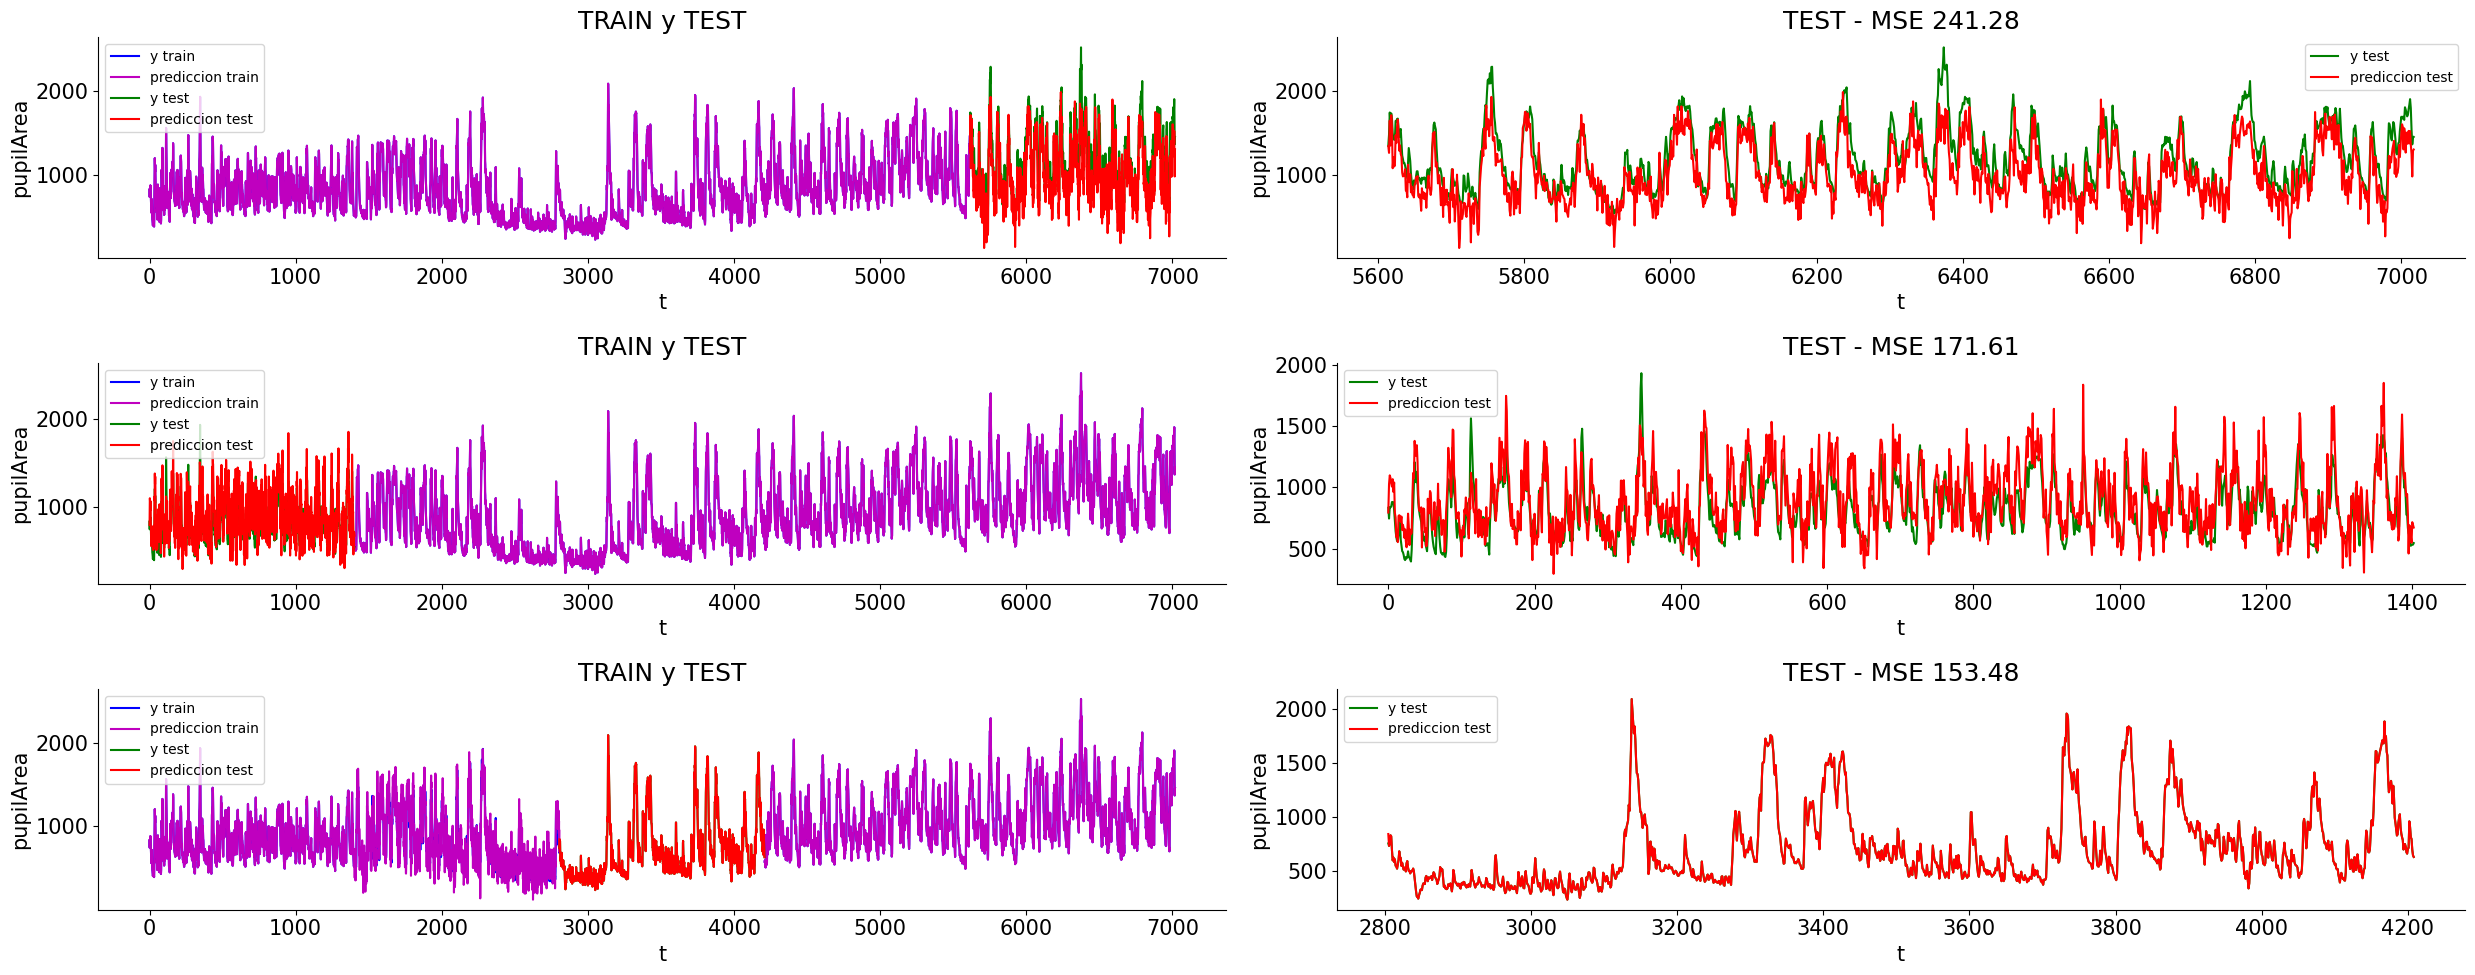

In [ ]:
#@title Resultados
L = np.min([3,fold])
plt.figure(figsize=(25,10))
for I in range(L):
  IDX_TRAIN, IDX_TEST = indices[int(I*fold/(L))]
  model = modelos_lineales[I]

  plt.subplot(L,2,2*I+1)
  discont = np.where(np.diff(IDX_TRAIN)!=1)
  if len(discont[0])>0:
    idx1 = IDX_TRAIN[:discont[0][0]+1]
    idx2 = IDX_TRAIN[discont[0][0]+1:]
    plt.plot(idx1,dat[variable][idx1],'b')
    plt.plot(idx2,dat[variable][idx2],'b',label='y train')
    plt.plot(idx1,model.predict(Z[:,idx1].T),'m')
    plt.plot(idx2,model.predict(Z[:,idx2].T),'m',label='prediccion train')
  else:
    X_train, y_train = Z[:,IDX_TRAIN], dat[variable][IDX_TRAIN]
    plt.plot(IDX_TRAIN,y_train,'b',label='y train')
    plt.plot(IDX_TRAIN,model.predict(X_train.T),'m',label='prediccion train')

  discont = np.where(np.diff(IDX_TEST)!=1)
  if len(discont[0])>0:
    idx1 = IDX_TEST[:discont[0][0]+1]
    idx2 = IDX_TEST[discont[0][0]+1:]
    plt.plot(idx1,dat[variable][idx1],'g')
    plt.plot(idx2,dat[variable][idx2],'g',label='y test')
    plt.plot(idx1,model.predict(Z[:,idx1].T),'r')
    plt.plot(idx2,model.predict(Z[:,idx2].T),'r',label='prediccion test')
  else:
    X_test, y_test = Z[:,IDX_TEST], dat[variable][IDX_TEST]
    plt.plot(IDX_TEST,y_test,'g',label='y test')
    plt.plot(IDX_TEST,model.predict(X_test.T),'r',label='prediccion test')

  plt.xlabel('t')
  plt.ylabel(variable)
  plt.title('TRAIN y TEST')
  plt.legend(fontsize=10)

  plt.subplot(L,2,2*(I+1))
  if len(discont[0])>0:
    idx1 = IDX_TEST[:discont[0][0]+1]
    idx2 = IDX_TEST[discont[0][0]+1:]
    if len(idx1)>1:
      plt.plot(idx1,dat[variable][idx1],'g')
      plt.plot(idx1,model.predict(Z[:,idx1].T),'r')
    if len(idx2)>1:
      plt.plot(idx2,dat[variable][idx2],'g',label='y test')
      plt.plot(idx2,model.predict(Z[:,idx2].T),'r',label='prediccion test')
  else:
    X_test, y_test = Z[:,IDX_TEST], dat[variable][IDX_TEST]
    plt.plot(IDX_TEST,y_test,'g',label='y test')
    plt.plot(IDX_TEST,model.predict(X_test.T),'r',label='prediccion test')

  plt.xlabel('t')
  plt.ylabel(variable)
  plt.title('TEST - MSE '+str(np.round(np.abs(MSE[I]),2)))
  plt.legend(fontsize=10)

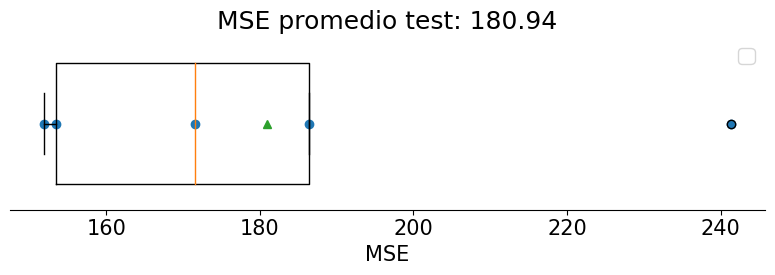

In [ ]:
# @title Resultados de evaluación: MSE de 'k=5'.
f, ax = plt.subplots(figsize=(8, 3))
accuracies = np.array(MSE)
ax.boxplot(accuracies, vert=False, widths=.7,showmeans=True)
ax.scatter(accuracies, np.ones(len(accuracies)))
ax.set(
  xlabel="MSE",
  yticks=[],
  title=f"MSE promedio evaluación: {np.round(accuracies.mean(),2)}"
)
ax.spines["left"].set_visible(False)
plt.show()

Y esta es la historia de cómo con una humilde regresión lineal pudimos leer comportamiento de actividad neuronal

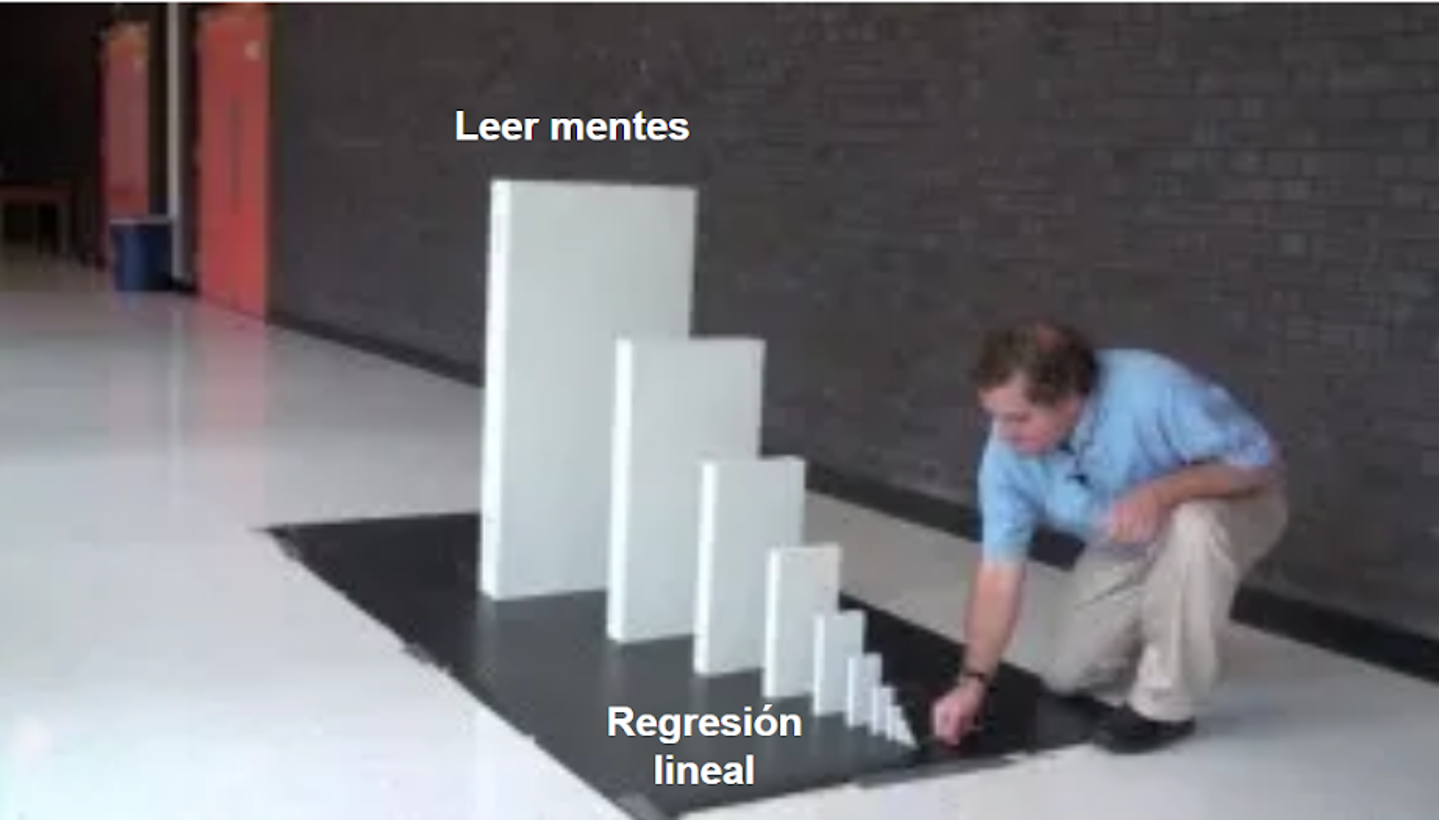